In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from nltk.corpus import stopwords
import keras.backend as K
from keras.models import Sequential
import string
import re

from tensorflow import keras
#import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input,Embedding,Dropout,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#import transformers
#import tokenizers
import os
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
#print("TensorFlow Datasets version: ",tfds.__version__)

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


from sklearn.metrics import accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TensorFlow version: 2.14.0


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

In [39]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [40]:
print('length of data is', len(data))

length of data is 1600000


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [42]:
data.target.value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [43]:
data['target'] = data['target'].replace(4,1)
data=data[['text','target']]
data.target.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [44]:
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [45]:
nltk.download('stopwords')
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manoj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
data['cleaned_text'] = data['text']
data.head()

,text,target,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...,0,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,"@nationwideclass no, it's not behaving at all...."


In [47]:
def strip_html(text):
  soup = BeautifulSoup(text, 'html.parser')
  return soup.get_text()

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    # Remove all special characters
    s = re.sub(r'[^a-zA-Z0-9\s]', '', s)
    return s

def apply_stemming_and_remove_stopwords(text):
    # Tokenize the text
    words = text.split()
    
    # Apply stemming
    ps = PorterStemmer()
    stemmed_words = [ps.stem(word) for word in words]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in stemmed_words if word.lower() not in stop_words]
    
    # Join the words back into a sentence
    processed_text = ' '.join(filtered_words)
    
    return processed_text


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = text.lower()
    text = clean_text(text)
    text = apply_stemming_and_remove_stopwords(text)
    return text



data['cleaned_text'] = data['cleaned_text'].apply(denoise_text)
data.head()

,text,target,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,0,upset cant updat hi facebook text might cri re...
2,@Kenichan I dived many times for the ball. Man...,0,dive mani time ball manag save 50 rest go bound
3,my whole body feels itchy and like its on fire,0,whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",0,behav im mad whi becaus cant see


In [48]:
data.tail(5)

,text,target,cleaned_text
1599995,Just woke up. Having no school is the best fee...,1,woke school best feel ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,thewdbcom veri cool hear old walt interview
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,readi mojo makeov ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,happi 38th birthday boo alll time tupac amaru ...
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1,happi charitytuesday


In [16]:
data.tail(5)

,text,target,cleaned_text
1599995,Just woke up. Having no school is the best fee...,1,woke up. school best feel ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,thewdb.com - veri cool hear old walt interview...
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,readi mojo makeover? ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,happi 38th birthday boo alll time!!! tupac ama...
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1,happi #charitytuesday


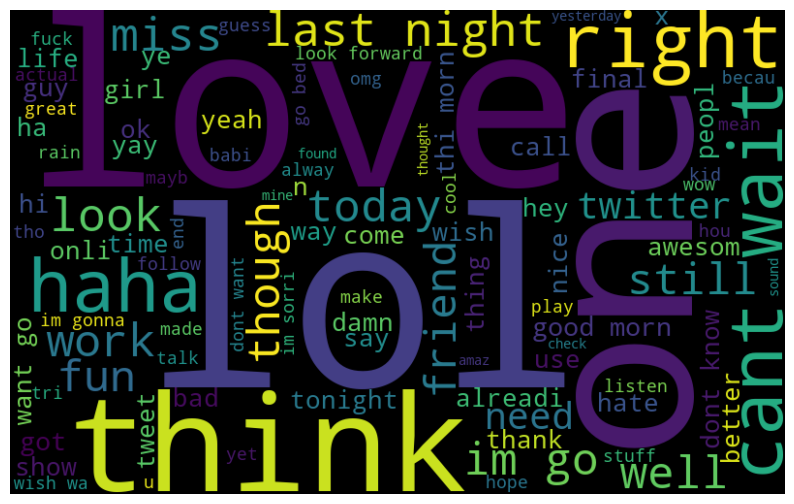

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#IMDB_df['cleaned_review'] = IMDB_df['review']
#IMDB_df.head()


wc = WordCloud(width=800, height=500, random_state=21, max_words=100, min_font_size=10).generate(' '.join(data['cleaned_text']))
plt.figure(figsize=(10, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [18]:
from nltk.util import ngrams
import nltk
nltk.download('punkt')
from collections import Counter

def generate_ngrams(text, n):
    n_grams = ngrams(text.split(), n)
    return [' '.join(grams) for grams in n_grams]


cleaned_text = data['cleaned_text']
all_text = ' '.join(cleaned_text)

bigrams = generate_ngrams(all_text, 2)
trigrams = generate_ngrams(all_text, 3)

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# 20 most common bigrams and trigrams
top_bigrams = bigram_counts.most_common(20)
top_trigrams = trigram_counts.most_common(20)


def plot_ngrams(top_ngrams, n):
    labels, values = zip(*top_ngrams)
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values, color='skyblue')
    plt.title(f'Top {n} {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')
    plt.show()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manoj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


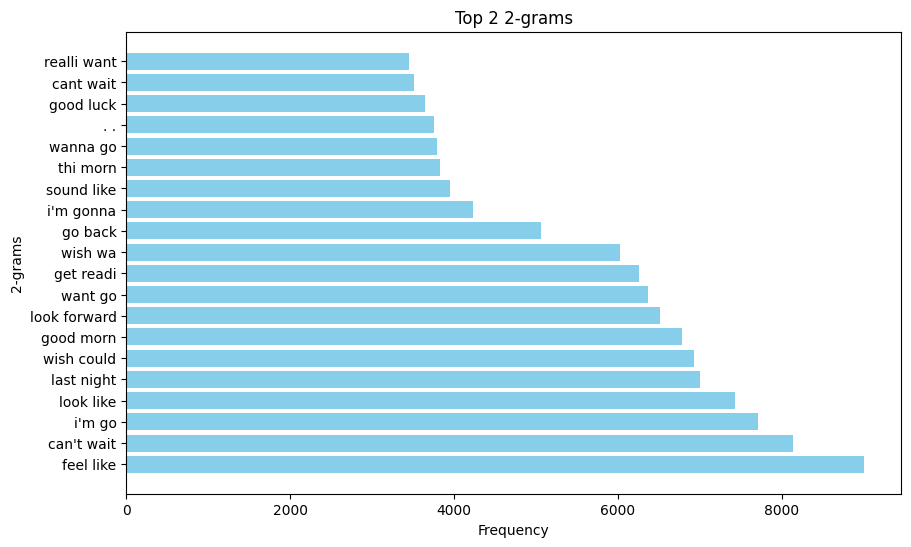

In [19]:
plot_ngrams(top_bigrams, 2)

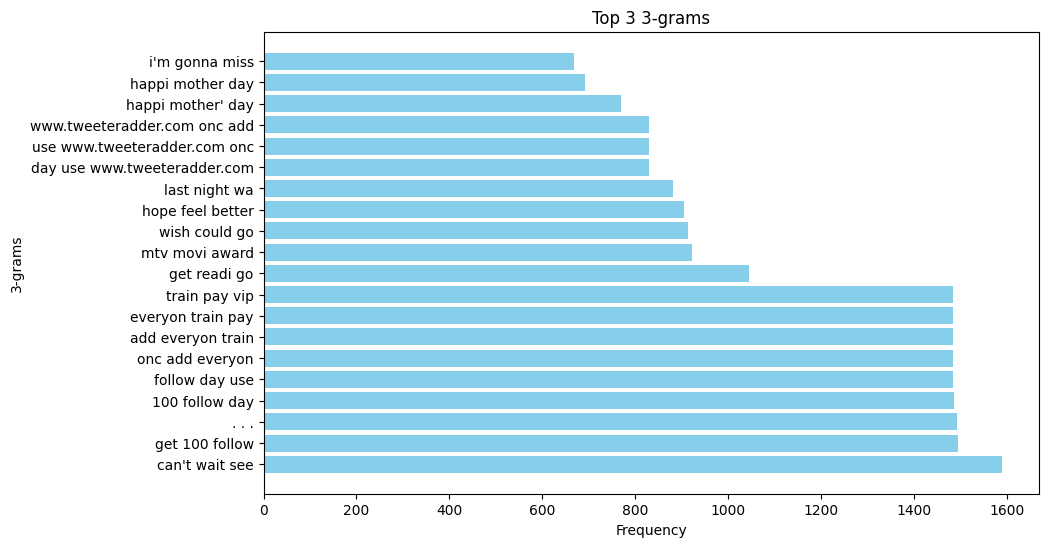

In [20]:
plot_ngrams(top_trigrams, 3)

In [50]:
#  Create X and y objects
X = data['cleaned_text']
y = data['target']

In [51]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming you have your features (X) and labels (y) loaded

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shufafle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size=1024)

# Batch the testing dataset
test_dataset = test_dataset.batch(batch_size=1024)

# Example: Iterate through batches in training dataset
for batch in train_dataset.take(1):
    features, labels = batch
    print("Batch shape:", features.shape)
    print("Labels shape:", labels.shape)

# Example: Iterate through batches in testing dataset
for batch in test_dataset.take(1):
    features, labels = batch
    print("Batch shape:", features.shape)
    print("Labels shape:", labels.shape)


Batch shape: (1024,)
Labels shape: (1024,)
Batch shape: (1024,)
Labels shape: (1024,)


In [52]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [53]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 960000 entries, 127008 to 820352
Series name: cleaned_text
Non-Null Count   Dtype 
--------------   ----- 
960000 non-null  object
dtypes: object(1)
memory usage: 14.6+ MB
